In [74]:
## fetch the data
from pathlib import Path
import pandas as pd
import tarfile
import urllib.request

def load_housing_data():
  tarball_path = Path('datasets/housing.tgz')

  if not tarball_path.is_file():
    Path('datasets').mkdir(parents=True, exist_ok=True)
    url = "https://github.com/ageron/data/raw/main/housing.tgz"
    urllib.request.urlretrieve(url, tarball_path)
    with tarfile.open(tarball_path) as housing_tarball:
      housing_tarball.extractall(path='datasets')
  return pd.read_csv('datasets/housing/housing.csv')

In [75]:
#load the data
housing = load_housing_data()

In [76]:
#print the head
housing.head()

longitude  latitude  housing_median_age  total_rooms  total_bedrooms  \
0    -122.23     37.88                41.0        880.0           129.0   
1    -122.22     37.86                21.0       7099.0          1106.0   
2    -122.24     37.85                52.0       1467.0           190.0   
3    -122.25     37.85                52.0       1274.0           235.0   
4    -122.25     37.85                52.0       1627.0           280.0   

   population  households  median_income  median_house_value ocean_proximity  
0       322.0       126.0         8.3252            452600.0        NEAR BAY  
1      2401.0      1138.0         8.3014            358500.0        NEAR BAY  
2       496.0       177.0         7.2574            352100.0        NEAR BAY  
3       558.0       219.0         5.6431            341300.0        NEAR BAY  
4       565.0       259.0         3.8462            342200.0        NEAR BAY

In [77]:
#print the info
housing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20433 non-null  float64
 5   population          20640 non-null  float64
 6   households          20640 non-null  float64
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  float64
 9   ocean_proximity     20640 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


`total_bedrooms` has some missing values 

`ocean_proximity` is an categorical attribute

In [78]:
housing['ocean_proximity'].value_counts()

ocean_proximity
<1H OCEAN     9136
INLAND        6551
NEAR OCEAN    2658
NEAR BAY      2290
ISLAND           5
Name: count, dtype: int64

Visualize the data

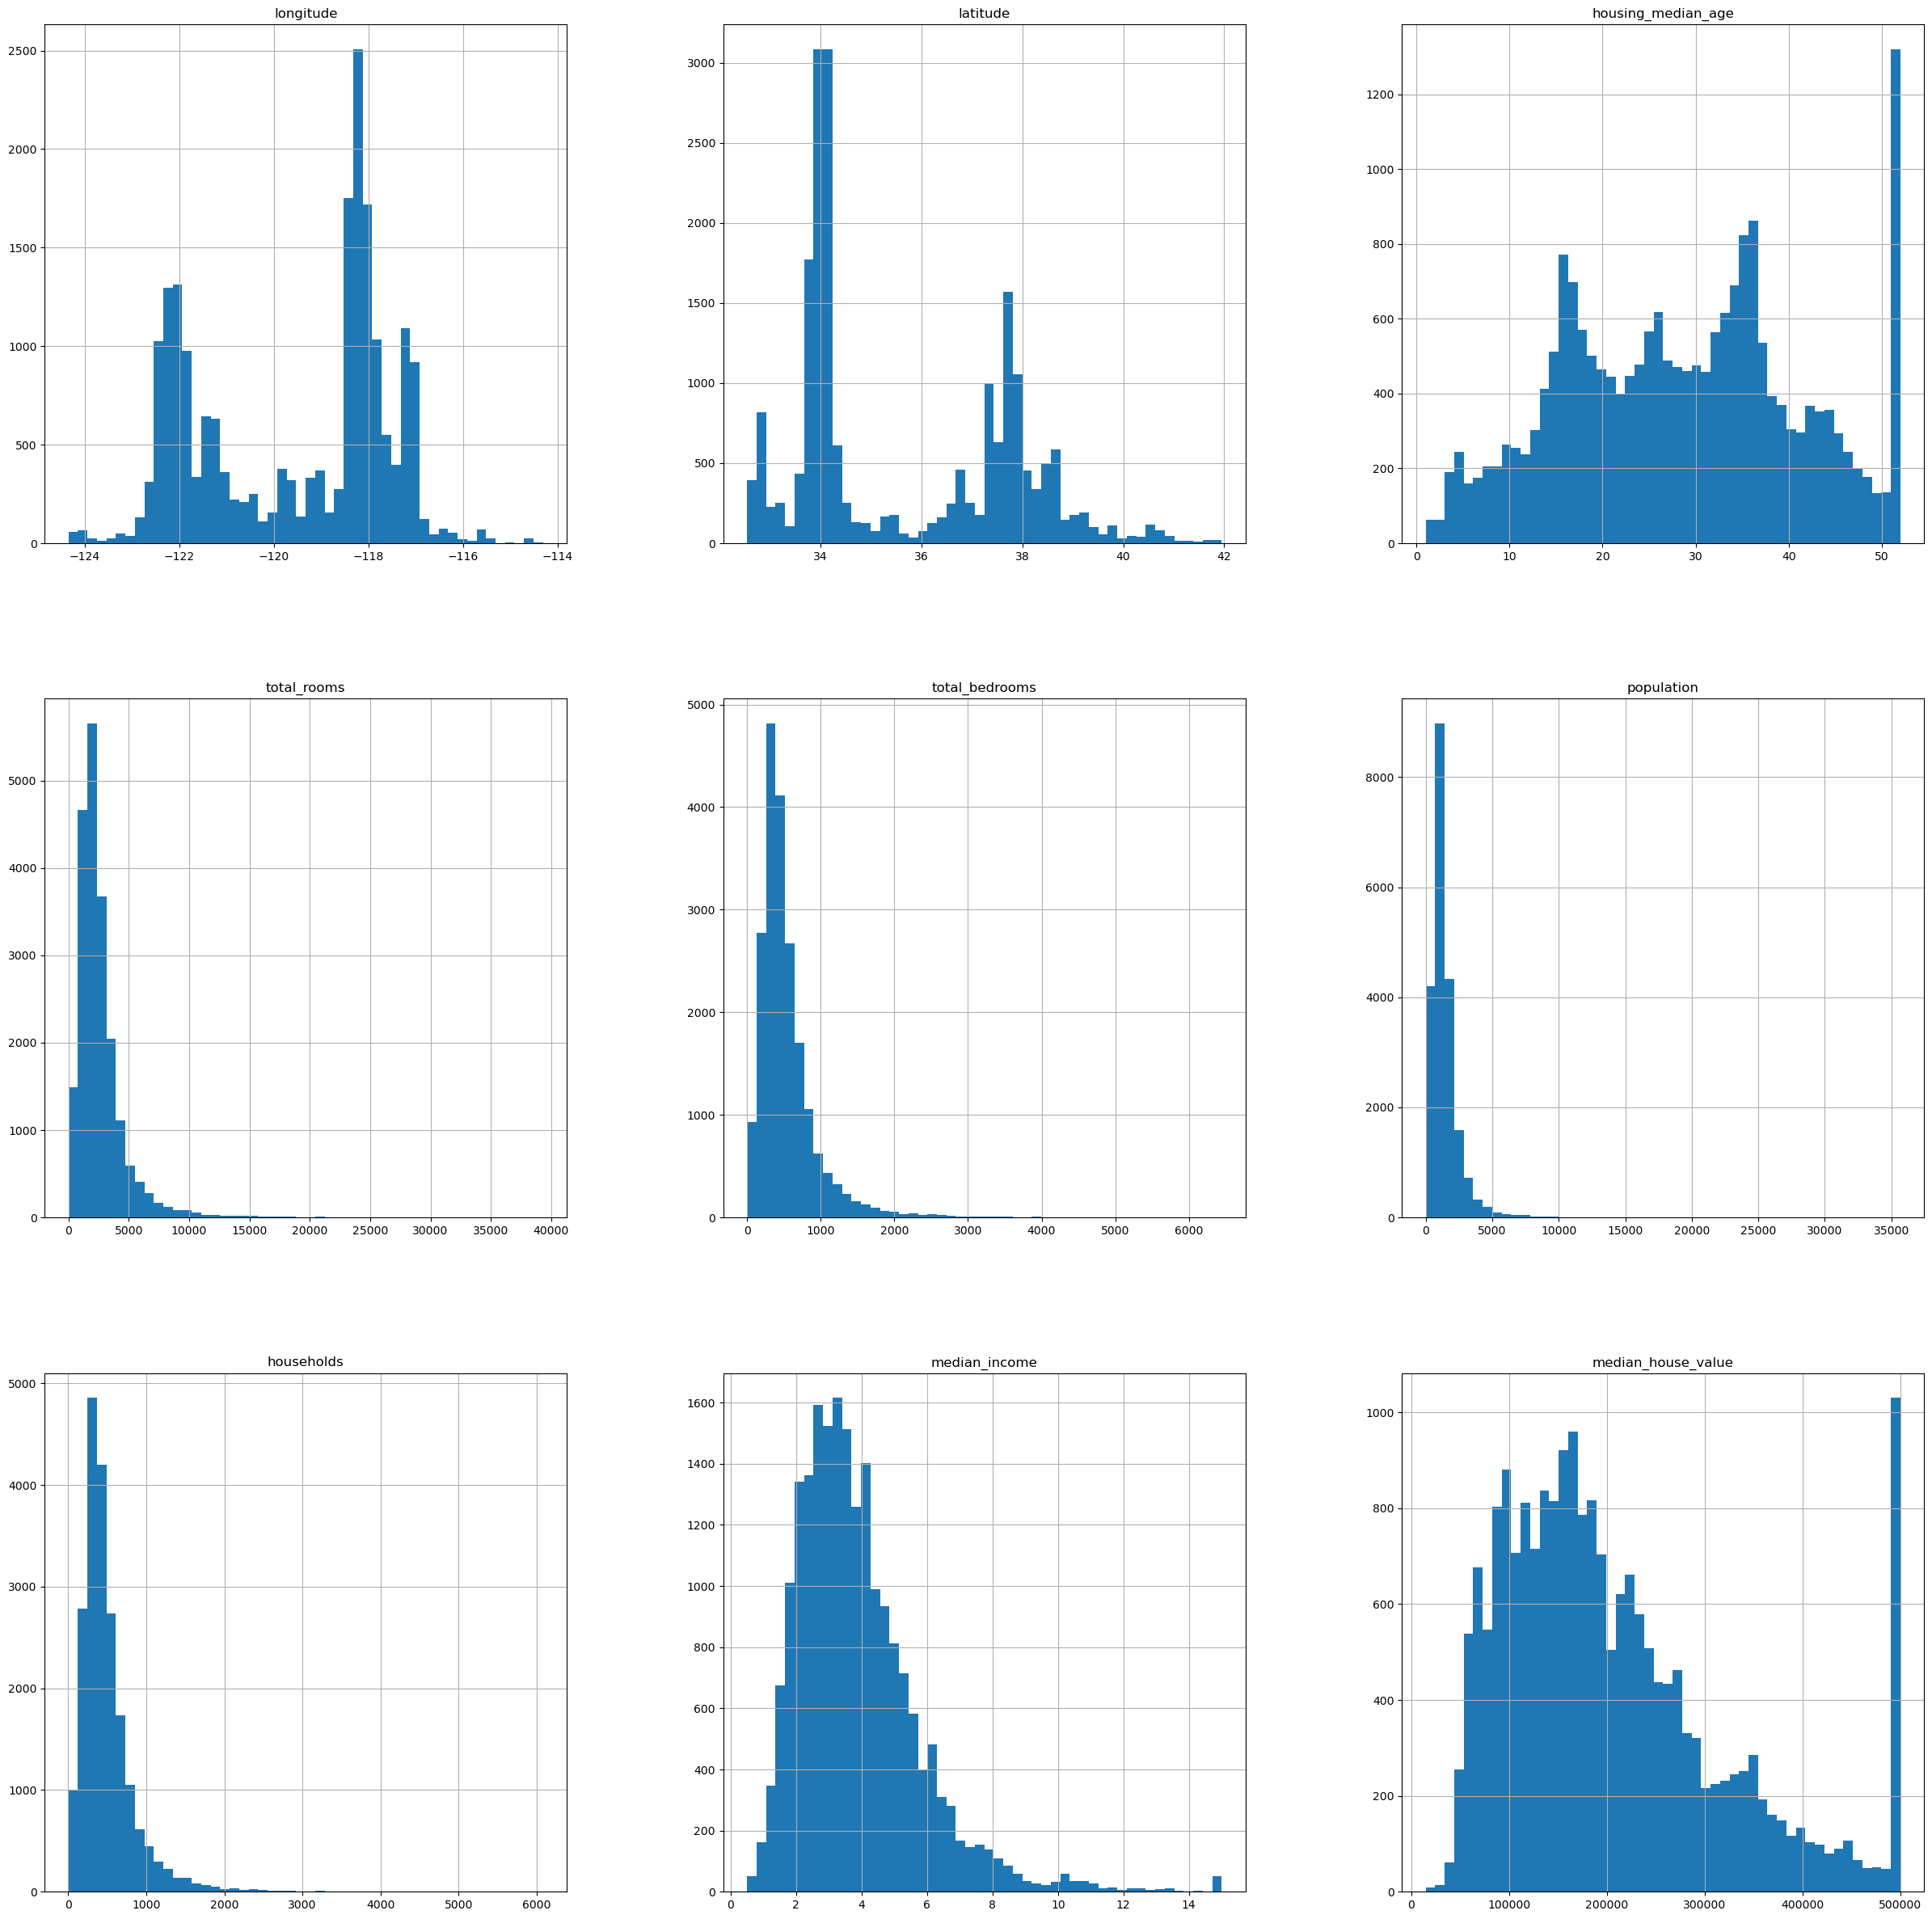

In [79]:
import matplotlib.pyplot as plt
import seaborn as sns 

housing.hist(bins=50,figsize=(30,30))
plt.subplots_adjust()
plt.show()

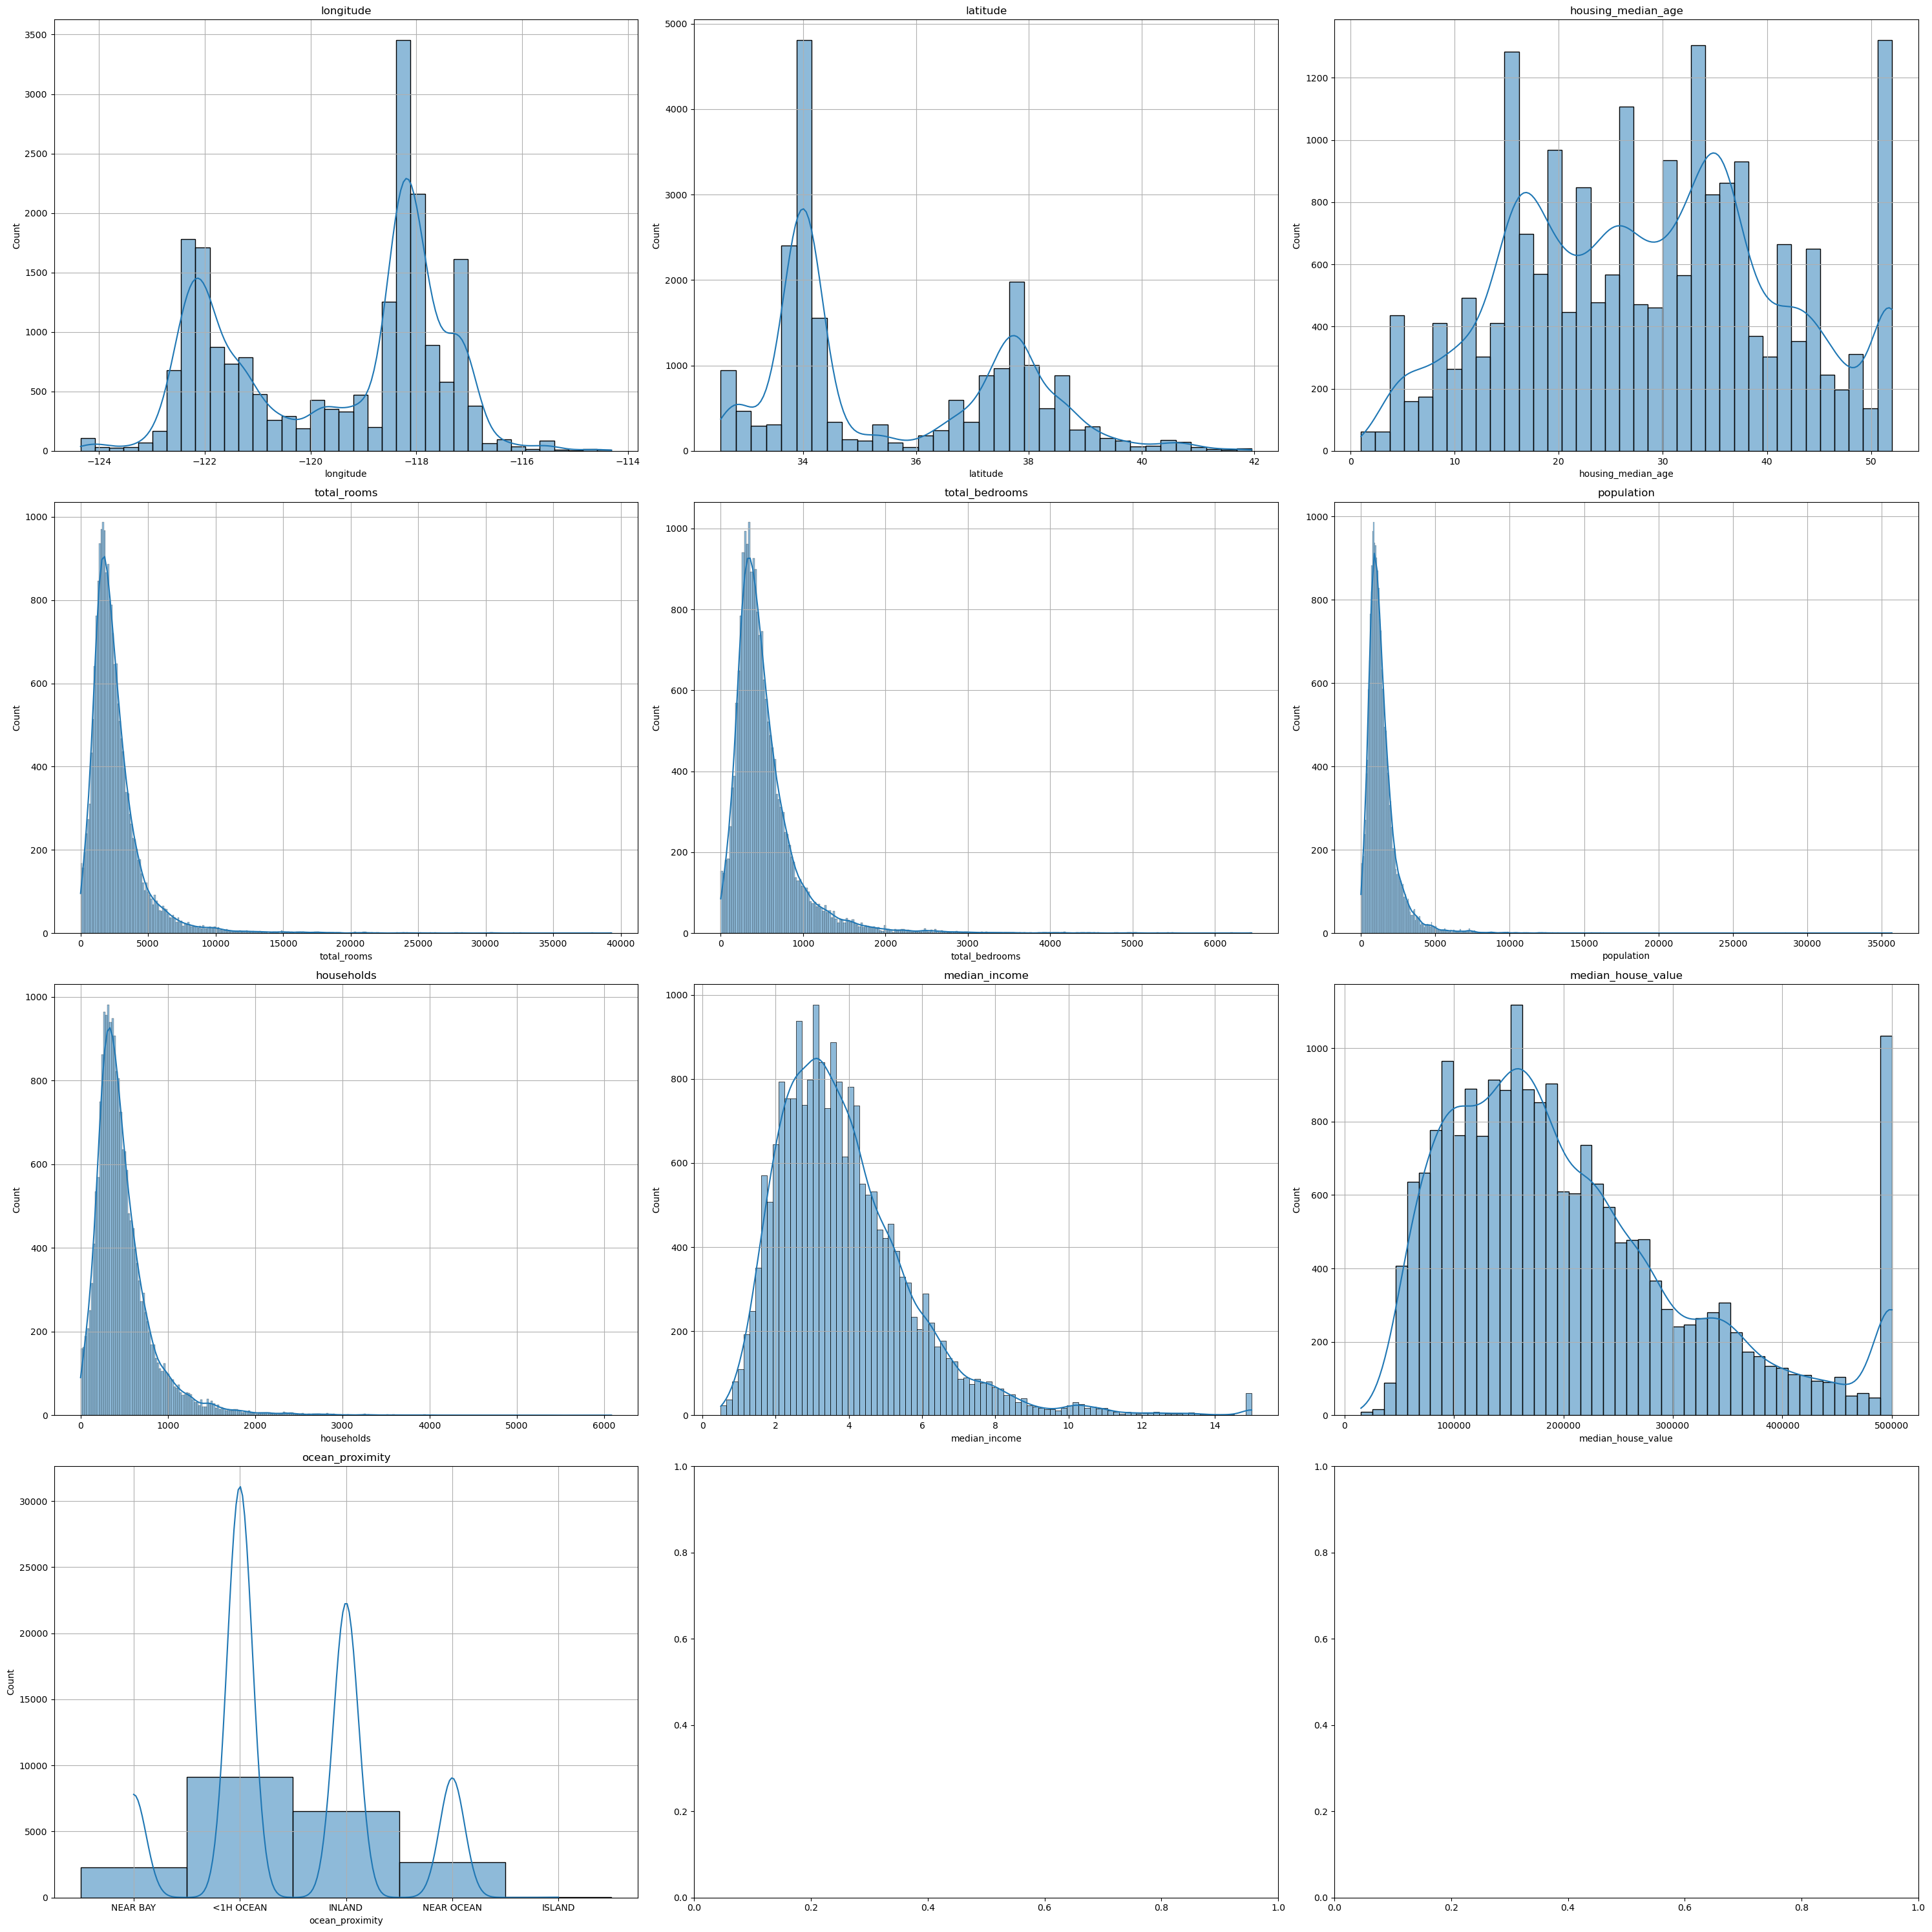

In [80]:
import math
num_features = len(housing.columns)
num_rows = math.ceil(num_features/3)

fig, ax = plt.subplots(num_rows, 3,figsize=(30,30))

ax = ax.flatten()

for i , column in enumerate(housing.columns):
  sns.histplot(data=housing, x=housing[column], ax = ax[i],kde=True)
  ax[i].set_title(column)
  ax[i].grid(True)

plt.tight_layout()
plt.show()

## Train set


In [81]:
from sklearn.model_selection import train_test_split

train_set, test_set = train_test_split(housing, test_size=0.2, random_state=42)

In [82]:
## Create a new column income_cat
import numpy as np
bins = [0,1.5,3.0,4.5,6,np.inf]
labels = [1,2,3,4,5]


housing['income_cat'] = pd.cut(housing['median_income'], bins = bins ,
                               labels=labels)

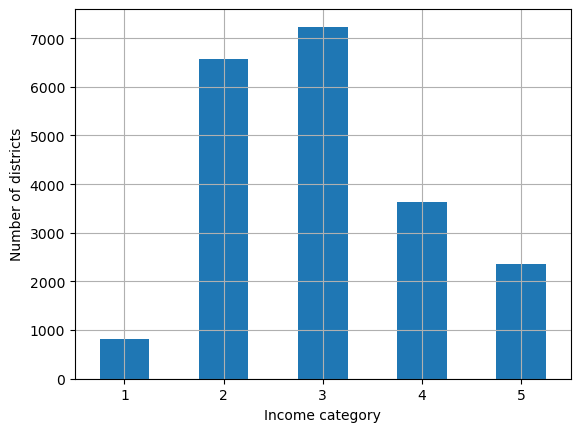

In [83]:
housing['income_cat'].value_counts().sort_index().plot.bar(rot= 0,grid=True)
plt.xlabel("Income category")
plt.ylabel("Number of districts")
plt.show()


Now we can do stratified sampling based on the `income_cat` attribute.

In [84]:
from sklearn.model_selection import StratifiedShuffleSplit

strat_train_set, strat_test_set = train_test_split(housing, test_size=0.2, stratify= housing['income_cat'],
                                                                                            random_state=42)

The stratify parameter in the train_test_split function from sklearn.model_selection ensures that the train and test sets have approximately the same percentage of samples of each target class as the complete set.

In [85]:
#Now we can drop the income_cat column
for set_ in (strat_test_set ,strat_train_set):
  set_.drop('income_cat', axis=1, inplace=True)

## Visualize the data


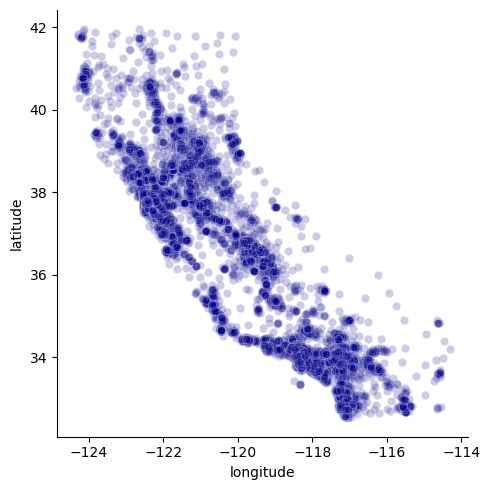

In [86]:
sns.relplot(kind='scatter',data=housing, x='longitude', y='latitude', alpha=0.2, color="darkblue")

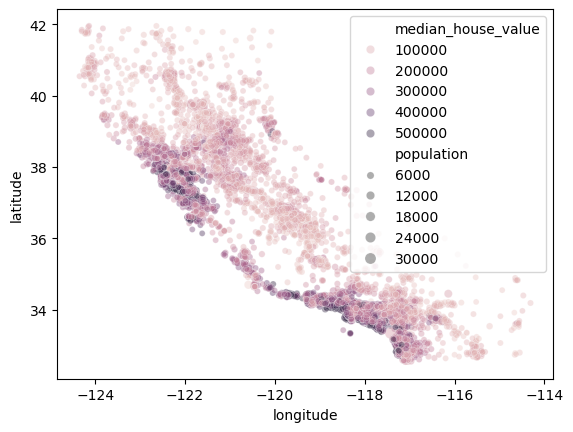

In [87]:
sns.scatterplot(data=housing, x='longitude', y='latitude', alpha=0.4, hue='median_house_value',size='population')
plt.show()

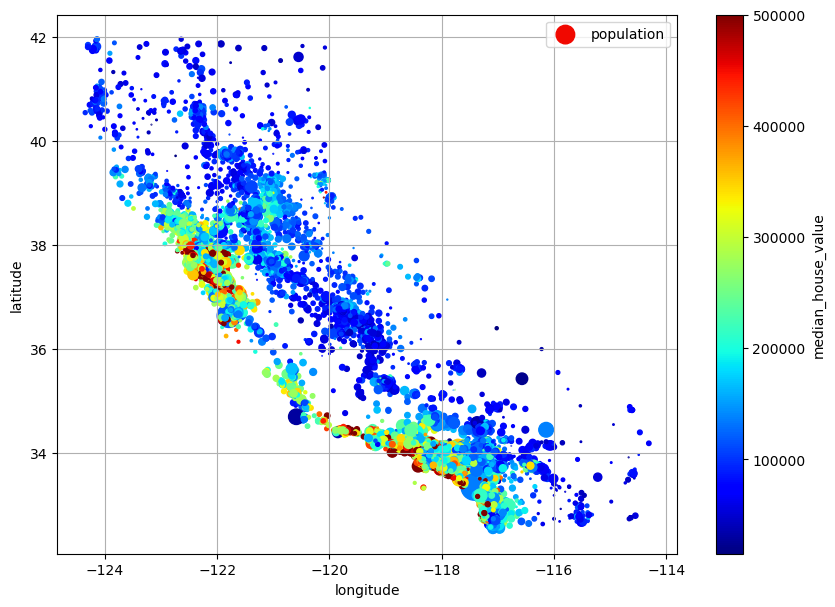

In [88]:
housing.plot(kind="scatter", x="longitude", y="latitude", grid=True,
 s=housing["population"] / 100, label="population",
 c="median_house_value", cmap="jet", colorbar=True,
 legend=True, sharex=False, figsize=(10, 7))
plt.show()


Look for correlations

<Axes: >

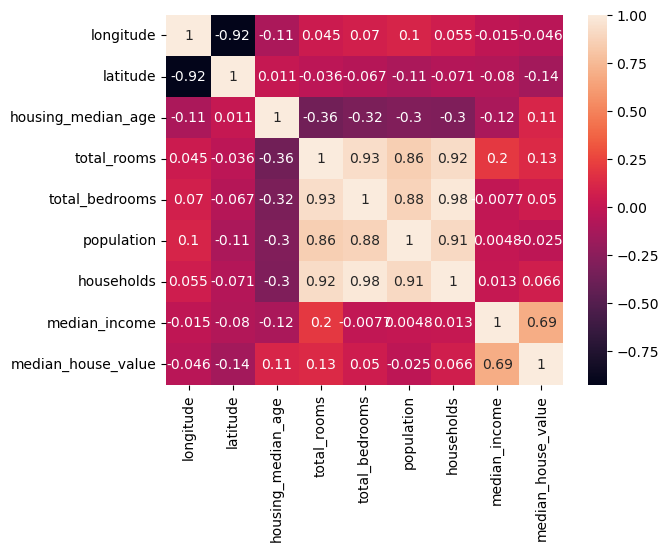

In [89]:
# Identify numeric columns in the DataFrame
numeric_columns = housing.select_dtypes(include=[np.number]).columns

# Calculate correlation only on numeric columns
corr_matrix = housing[numeric_columns].corr()

# Plot the heatmap
sns.heatmap(corr_matrix, annot=True)

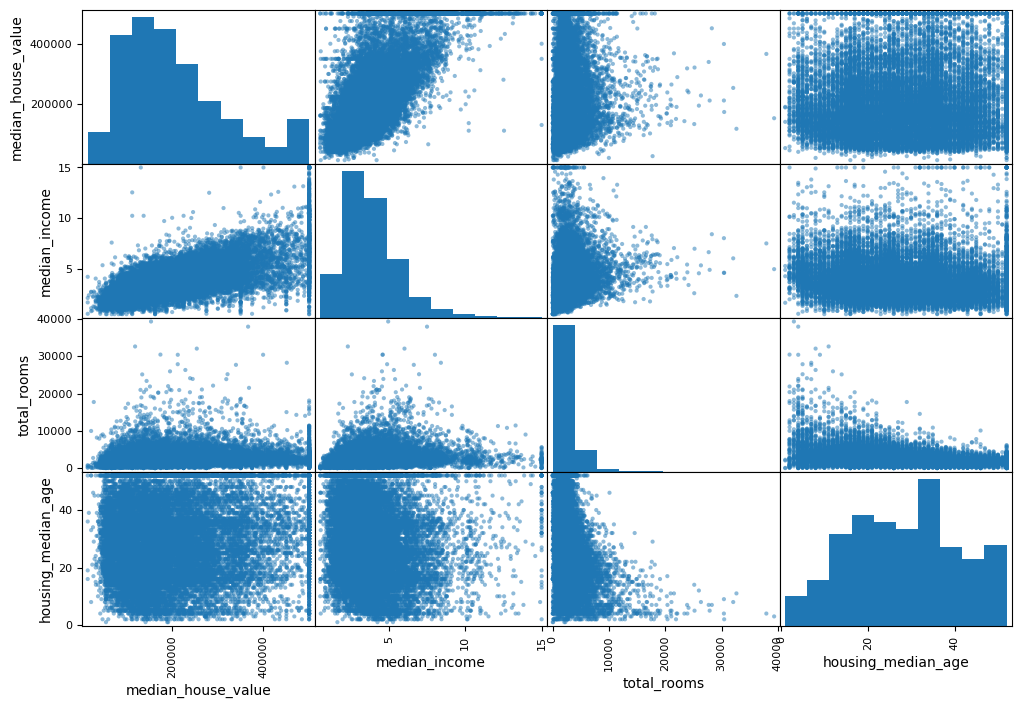

In [90]:
from pandas.plotting import scatter_matrix

atributes = ['median_house_value', 'median_income', 'total_rooms', 'housing_median_age']
scatter_matrix(housing[atributes], figsize=(12,8))  
plt.show()

<Axes: xlabel='median_income', ylabel='median_house_value'>

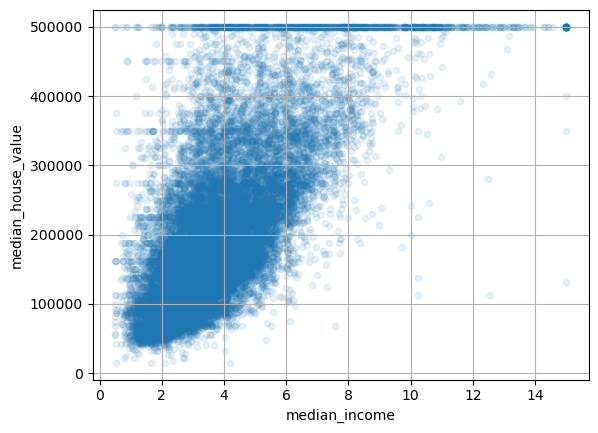

In [91]:
housing.plot(kind='scatter', x='median_income', y='median_house_value', alpha=0.1, grid=True)

We can try adding new features as well

In [92]:

housing["rooms_per_house"] = housing["total_rooms"] / housing["households"]
housing["bedrooms_ratio"] = housing["total_bedrooms"] / housing["total_rooms"]
housing["people_per_house"] = housing["population"] / housing["households"]

<Axes: >

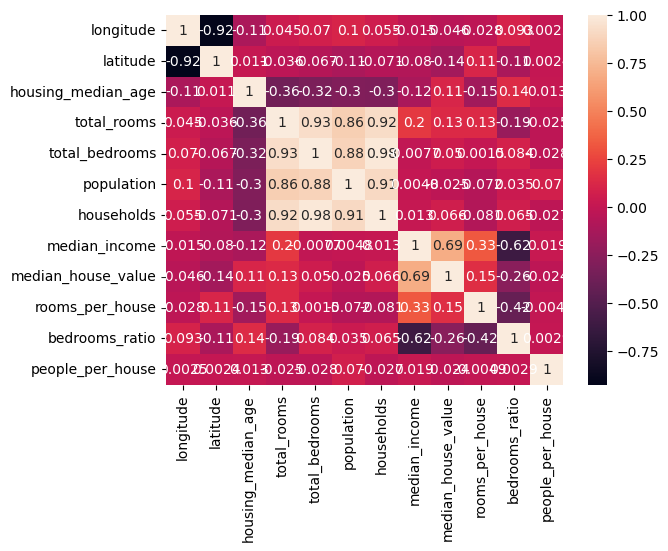

In [93]:
numeric_columns = housing.select_dtypes(include=[np.number]).columns


sns.heatmap(housing[numeric_columns].corr(), annot=True)

In [94]:
housing[numeric_columns].corr().loc[:,'median_house_value'].sort_values(ascending=False)

median_house_value    1.000000
median_income         0.688075
rooms_per_house       0.151948
total_rooms           0.134153
housing_median_age    0.105623
households            0.065843
total_bedrooms        0.049686
people_per_house     -0.023737
population           -0.024650
longitude            -0.045967
latitude             -0.144160
bedrooms_ratio       -0.255880
Name: median_house_value, dtype: float64

`bedrooms_ratio` has some correlation with the `median_house_value`

## Prepare the data for ML Algorithms

In [95]:
housing = strat_train_set.drop('median_house_value', axis=1)
housing_labels = strat_train_set['median_house_value'].copy()

> Clean the data


In [96]:
# impute the data in total_bedrooms by median()
# median = housing['total_bedrooms'].median()
# housing['total_bedrooms'].fillna(median, inplace=True)
housing.info()

<class 'pandas.core.frame.DataFrame'>
Index: 16512 entries, 13096 to 19888
Data columns (total 9 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           16512 non-null  float64
 1   latitude            16512 non-null  float64
 2   housing_median_age  16512 non-null  float64
 3   total_rooms         16512 non-null  float64
 4   total_bedrooms      16344 non-null  float64
 5   population          16512 non-null  float64
 6   households          16512 non-null  float64
 7   median_income       16512 non-null  float64
 8   ocean_proximity     16512 non-null  object 
dtypes: float64(8), object(1)
memory usage: 1.3+ MB


> We will use SimpleImputer to impute so that we can use imputing for validation and test set also

In [97]:
from sklearn.impute import SimpleImputer

imputer = SimpleImputer(strategy='median')

In [98]:
housing_num = housing.select_dtypes(include=[np.number])

In [99]:
##fit the imputer
imputer.fit(housing_num)

SimpleImputer(strategy='median')

In [100]:
imputer.statistics_

array([-118.51  ,   34.26  ,   29.    , 2125.    ,  434.    , 1167.    ,
        408.    ,    3.5385])

In [101]:
housing_num.median().values

array([-118.51  ,   34.26  ,   29.    , 2125.    ,  434.    , 1167.    ,
        408.    ,    3.5385])

In [102]:
x = imputer.transform(housing_num)

In [103]:
housing_tr = pd.DataFrame(x, columns=housing_num.columns, index=housing_num.index)

#### Handling categorical attributes


In [104]:
## ocean_proximity
housing_cat = housing[['ocean_proximity']]

In [105]:
housing_cat.head(8)

ocean_proximity
13096        NEAR BAY
14973       <1H OCEAN
3785           INLAND
14689          INLAND
20507      NEAR OCEAN
1286           INLAND
18078       <1H OCEAN
4396         NEAR BAY

> We will use OneHotEncoder for converting categorical values to numerical values

In [106]:
from sklearn.preprocessing import OneHotEncoder
cat_encoder = OneHotEncoder()
housing_cat_1hot = cat_encoder.fit_transform(housing_cat)

In [107]:
housing_cat_1hot

<16512x5 sparse matrix of type '<class 'numpy.float64'>'
	with 16512 stored elements in Compressed Sparse Row format>

In [108]:
housing_cat_1hot.toarray()

array([[0., 0., 0., 1., 0.],
       [1., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0.],
       ...,
       [0., 0., 0., 0., 1.],
       [1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1.]])

#### Feature scaling and Transformation

The total number of rooms ranges from about 6 to 39,320, while the median incomes only range from 0 to 15.

In [109]:
## Min-Max Scaling
from sklearn.preprocessing import MinMaxScaler

min_max_scaler = MinMaxScaler(feature_range=(-1,1))
housing_num_min_max_scaled = min_max_scaler.fit_transform(housing_num)

In [110]:
##Standardization
from sklearn.preprocessing import StandardScaler

std_scaler = StandardScaler()
housing_num_std_scaled = std_scaler.fit_transform(housing_num)

### We will have to manage the columns which are right skewed which can be done by using log transformation or the rbf kernel function

In [111]:
from sklearn.metrics.pairwise import rbf_kernel

age_simil_35 = rbf_kernel(housing[['housing_median_age']],[[35]], gamma=0.1)

#### <b> Transformation Pipelines </b>

In [112]:
from sklearn.pipeline import Pipeline

num_pipeline = Pipeline([
  ('impute', SimpleImputer(strategy='median')),
  ('standardize', StandardScaler())
  
])

In [113]:
num_pipeline

Pipeline(steps=[('impute', SimpleImputer(strategy='median')),
                ('standardize', StandardScaler())])

If the last estimator were a predictor instead
of a transformer, then the pipeline would have a predict() method rather than a
transform() method. Calling it would sequentially apply all the transformations to
the data and pass the result to the predictor’s predict() method.

In [114]:
housing_num_prepared = num_pipeline.fit_transform(housing_num)
housing_num_prepared[:2].round(2)


array([[-1.42,  1.01,  1.86,  0.31,  1.37,  0.14,  1.39, -0.94],
       [ 0.6 , -0.7 ,  0.91, -0.31, -0.44, -0.69, -0.37,  1.17]])

Handling categorical and numerical attribute together using 
<b> ColumnTransformer </b>

In [115]:
from sklearn.compose import ColumnTransformer, make_column_selector, make_column_transformer

# num_attribs = ["longitude", "latitude", "housing_median_age", "total_rooms",
#  "total_bedrooms", "population", "households", "median_income"]
# cat_attribs = ["ocean_proximity"]

cat_pipeline = Pipeline([
  ('imputer', SimpleImputer(strategy='most_frequent')),
  ('encoder', OneHotEncoder(handle_unknown='ignore'))
])

preprocessing = ColumnTransformer([
  ('num', num_pipeline, make_column_selector(dtype_include=np.number)),
  ('cat', cat_pipeline, make_column_selector(dtype_include=object))
])

In [116]:
housing_prepared = preprocessing.fit_transform(housing)

In [117]:
preprocessing.get_feature_names_out() 

array(['num__longitude', 'num__latitude', 'num__housing_median_age',
       'num__total_rooms', 'num__total_bedrooms', 'num__population',
       'num__households', 'num__median_income',
       'cat__ocean_proximity_<1H OCEAN', 'cat__ocean_proximity_INLAND',
       'cat__ocean_proximity_ISLAND', 'cat__ocean_proximity_NEAR BAY',
       'cat__ocean_proximity_NEAR OCEAN'], dtype=object)

## Make the final pipeline

In [118]:
from sklearn.preprocessing import FunctionTransformer
from sklearn.pipeline import make_pipeline

In [119]:
def column_ratio(X):
  return X[:,[0]]/X[:,[1]]

In [120]:
def ratio_name(function_transformer, feature_names_in):
  return ['ratio'] #feature names out

In [121]:
def ratio_pipeline():
  return make_pipeline(
    SimpleImputer(strategy='median'),
    FunctionTransformer(column_ratio, feature_names_out=ratio_name),
    StandardScaler()
  )

In [122]:
log_pipeline = make_pipeline(
  SimpleImputer(strategy='median'),
  FunctionTransformer(np.log, feature_names_out='one-to-one'),
  StandardScaler()
)

In [123]:
from sklearn.cluster import KMeans
from sklearn.base import BaseEstimator, TransformerMixin

class ClusterSimilarity(BaseEstimator, TransformerMixin):
  def __init__(self, n_clusters=10, gamma=1.0, random_state=None):
    self.n_clusters = n_clusters
    self.gamma = gamma
    self.random_state = random_state
  def fit(self, X, y=None, sample_weight=None):
    self.kmeans_ = KMeans(self.n_clusters, random_state=self.random_state)
    self.kmeans_.fit(X, sample_weight=sample_weight)
    return self # always return self!
  def transform(self, X):
    return rbf_kernel(X, self.kmeans_.cluster_centers_, gamma=self.gamma)
  def get_feature_names_out(self, names=None):
    return [f"Cluster {i} similarity" for i in range(self.n_clusters)]

In [124]:
cluster_simil = ClusterSimilarity(n_clusters=10, gamma=1., random_state=42)

In [125]:
default_num_pipeline = make_pipeline(
  SimpleImputer(strategy='median'),
  StandardScaler()
)

In [126]:
preprocessing = ColumnTransformer([
 ("bedrooms", ratio_pipeline(), ["total_bedrooms", "total_rooms"]),
 ("rooms_per_house", ratio_pipeline(), ["total_rooms", "households"]),
 ("people_per_house", ratio_pipeline(), ["population", "households"]),
 ("log", log_pipeline, ["total_bedrooms", "total_rooms", "population",
 "households", "median_income"]),
 ("geo", cluster_simil, ["latitude", "longitude"]),
 ("cat", cat_pipeline, make_column_selector(dtype_include=object)),
],
remainder=default_num_pipeline) # one column remaining: housing_median_age

In [127]:
# from sklearn.preprocessing import FunctionTransformer, StandardScaler, OneHotEncoder
# from sklearn.pipeline import make_pipeline, Pipeline
# from sklearn.impute import SimpleImputer
# from sklearn.compose import ColumnTransformer, make_column_selector
# from sklearn.cluster import KMeans
# from sklearn.base import BaseEstimator, TransformerMixin
# import numpy as np
# from sklearn.metrics.pairwise import rbf_kernel

# def column_ratio(X):
#     return X[:, [0]] / X[:, [1]]

# def ratio_name(function_transformer, feature_names_in):
#     return ['ratio']

# def ratio_pipeline():
#     return make_pipeline(
#         SimpleImputer(strategy='median'),
#         FunctionTransformer(column_ratio, feature_names_out=ratio_name),
#         StandardScaler()
#     )

# log_pipeline = make_pipeline(
#     SimpleImputer(strategy='median'),
#     FunctionTransformer(np.log1p, feature_names_out='one-to-one'),
#     StandardScaler()
# )

# class ClusterSimilarity(BaseEstimator, TransformerMixin):
#     def __init__(self, n_clusters=10, gamma=1.0, random_state=None):
#         self.n_clusters = n_clusters
#         self.gamma = gamma
#         self.random_state = random_state

#     def fit(self, X, y=None, sample_weight=None):
#         self.kmeans_ = KMeans(self.n_clusters, random_state=self.random_state)
#         self.kmeans_.fit(X, sample_weight=sample_weight)
#         return self

#     def transform(self, X):
#         return rbf_kernel(X, self.kmeans_.cluster_centers_, gamma=self.gamma)

#     def get_feature_names_out(self, names=None):
#         return [f"Cluster {i} similarity" for i in range(self.n_clusters)]

# cluster_simil = Pipeline([
#     ('cluster', ClusterSimilarity(n_clusters=10, gamma=1.0, random_state=42))
# ])

# cat_pipeline = Pipeline([
#     ('imputer', SimpleImputer(strategy='most_frequent')),
#     ('onehot', OneHotEncoder(handle_unknown='ignore'))
# ])

# default_num_pipeline = make_pipeline(
#     SimpleImputer(strategy='median'),
#     StandardScaler()
# )

# preprocessing = ColumnTransformer(
#     transformers=[
#         ("bedrooms", ratio_pipeline(), ["total_bedrooms", "total_rooms"]),
#         ("rooms_per_house", ratio_pipeline(), ["total_rooms", "households"]),
#         ("people_per_house", ratio_pipeline(), ["population", "households"]),
#         ("log", log_pipeline, ["total_bedrooms", "total_rooms", "population", "households", "median_income"]),
#         ("geo", cluster_simil, ["latitude", "longitude"]),
#         ("cat", cat_pipeline, make_column_selector(dtype_include=object)),
#     ],
#     remainder=default_num_pipeline
# )

# # Assuming 'data' is your DataFrame
# # preprocessing.fit(data)


In [128]:
housing_prepared = preprocessing.fit_transform(housing)

In [129]:
housing_prepared.shape

(16512, 24)

In [130]:
preprocessing.get_feature_names_out()

array(['bedrooms__ratio', 'rooms_per_house__ratio',
       'people_per_house__ratio', 'log__total_bedrooms',
       'log__total_rooms', 'log__population', 'log__households',
       'log__median_income', 'geo__Cluster 0 similarity',
       'geo__Cluster 1 similarity', 'geo__Cluster 2 similarity',
       'geo__Cluster 3 similarity', 'geo__Cluster 4 similarity',
       'geo__Cluster 5 similarity', 'geo__Cluster 6 similarity',
       'geo__Cluster 7 similarity', 'geo__Cluster 8 similarity',
       'geo__Cluster 9 similarity', 'cat__ocean_proximity_<1H OCEAN',
       'cat__ocean_proximity_INLAND', 'cat__ocean_proximity_ISLAND',
       'cat__ocean_proximity_NEAR BAY', 'cat__ocean_proximity_NEAR OCEAN',
       'remainder__housing_median_age'], dtype=object)

## Train the model

In [131]:
from sklearn.linear_model import LinearRegression

lin_reg = make_pipeline(preprocessing, LinearRegression())
lin_reg.fit(housing, housing_labels)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder=Pipeline(steps=[('simpleimputer',
                                                              SimpleImputer(strategy='median')),
                                                             ('standardscaler',
                                                              StandardScaler())]),
                                   transformers=[('bedrooms',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('functiontransformer',
                                                                   FunctionTransformer(feature_names_out=<function ratio_name at 0x000...
                                                   'households',
                                                   'median_income']),
                                                 ('geo',
                                                  ClusterSimilarity(random_state=42),
                                                  ['latitude', 'longitude']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('encoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x000002216F1CA360>)])),
                ('linearregression', LinearRegression())])

In [132]:
housing_predicitions = lin_reg.predict(housing)
housing_predicitions[:5].round(-2) #nearest hundred

array([246000., 372700., 135700.,  91400., 330900.])

In [133]:
housing_labels.iloc[:5]

13096    458300.0
14973    483800.0
3785     101700.0
14689     96100.0
20507    361800.0
Name: median_house_value, dtype: float64

In [134]:
from sklearn.metrics import mean_squared_error

lin_rmse = mean_squared_error(housing_labels, housing_predicitions, squared=False)

c:\Users\91934\anaconda3\envs\islp\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


In [135]:
lin_rmse

68972.88910758485

In [136]:
##Lets try a decision tree
from sklearn.tree import DecisionTreeRegressor

tree_reg =make_pipeline(preprocessing, DecisionTreeRegressor())
tree_reg.fit(housing, housing_labels)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder=Pipeline(steps=[('simpleimputer',
                                                              SimpleImputer(strategy='median')),
                                                             ('standardscaler',
                                                              StandardScaler())]),
                                   transformers=[('bedrooms',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('functiontransformer',
                                                                   FunctionTransformer(feature_names_out=<function ratio_name at 0x000...
                                                   'median_income']),
                                                 ('geo',
                                                  ClusterSimilarity(random_state=42),
                                                  ['latitude', 'longitude']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('encoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x000002216F1CA360>)])),
                ('decisiontreeregressor', DecisionTreeRegressor())])

In [137]:
housing_predicitions = tree_reg.predict(housing)
tree_rmse = mean_squared_error(housing_labels, housing_predicitions, squared=False)
tree_rmse

c:\Users\91934\anaconda3\envs\islp\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


0.0

The decision tree model has overfitted the data

The following code randomly splits the training set into 10 nonoverlapping subsets called folds,
then it trains and evaluates the decision tree model 10 times, picking a different fold
for evaluation every time and using the other 9 folds for training. The result is an
array containing the 10 evaluation score

In [144]:
## Using cross evaluation
from sklearn.model_selection import cross_val_score

tree_rmses = -cross_val_score(tree_reg,housing, housing_labels,scoring='neg_root_mean_squared_error', cv=10)


In [145]:
pd.Series(tree_rmses).describe()

count       10.000000
mean     66811.462239
std       1554.116632
min      64473.215742
25%      65716.378673
50%      66684.211140
75%      67988.142489
max      69450.465397
dtype: float64

In [147]:
## Lets try the Random Forest Regressor
from sklearn.ensemble import RandomForestRegressor

forest_reg = make_pipeline(preprocessing, RandomForestRegressor(random_state=42))

forest_rmses = -cross_val_score(forest_reg, housing, housing_labels,
 scoring="neg_root_mean_squared_error", cv=10)


In [149]:
pd.Series(forest_rmses).describe()

count       10.000000
mean     47124.604437
std       1069.311372
min      45292.329302
25%      46712.106520
50%      47172.209883
75%      47561.377695
max      49354.705514
dtype: float64

In [151]:
from sklearn.model_selection import GridSearchCV
full_pipeline = Pipeline([
 ("preprocessing", preprocessing),
 ("random_forest", RandomForestRegressor(random_state=42)),
])
param_grid = [
 {'preprocessing__geo__n_clusters': [5, 8, 10],
 'random_forest__max_features': [4, 6, 8]},
 {'preprocessing__geo__n_clusters': [10, 15],
 'random_forest__max_features': [6, 8, 10]},
]
grid_search = GridSearchCV(full_pipeline, param_grid, cv=3,
 scoring='neg_root_mean_squared_error', verbose=3)
grid_search.fit(housing, housing_labels)


Fitting 3 folds for each of 15 candidates, totalling 45 fits
[CV 1/3] END preprocessing__geo__n_clusters=5, random_forest__max_features=4;, score=-47538.458 total time=   5.6s
[CV 2/3] END preprocessing__geo__n_clusters=5, random_forest__max_features=4;, score=-47321.707 total time=   5.8s
[CV 3/3] END preprocessing__geo__n_clusters=5, random_forest__max_features=4;, score=-48751.883 total time=   5.6s
[CV 1/3] END preprocessing__geo__n_clusters=5, random_forest__max_features=6;, score=-47213.367 total time=   7.5s
[CV 2/3] END preprocessing__geo__n_clusters=5, random_forest__max_features=6;, score=-47008.203 total time=   7.7s
[CV 3/3] END preprocessing__geo__n_clusters=5, random_forest__max_features=6;, score=-48560.532 total time=   7.8s
[CV 1/3] END preprocessing__geo__n_clusters=5, random_forest__max_features=8;, score=-47377.929 total time=  10.7s
[CV 2/3] END preprocessing__geo__n_clusters=5, random_forest__max_features=8;, score=-47559.098 total time=  10.5s
[CV 3/3] END prepro

GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('preprocessing',
                                        ColumnTransformer(remainder=Pipeline(steps=[('simpleimputer',
                                                                                     SimpleImputer(strategy='median')),
                                                                                    ('standardscaler',
                                                                                     StandardScaler())]),
                                                          transformers=[('bedrooms',
                                                                         Pipeline(steps=[('simpleimputer',
                                                                                          SimpleImputer(strategy='median')),
                                                                                         ('functiontransformer',
                                                                                          FunctionTransformer(feature_names_out=<f...
                                                                         <sklearn.compose._column_transformer.make_column_selector object at 0x000002216F1CA360>)])),
                                       ('random_forest',
                                        RandomForestRegressor(random_state=42))]),
             param_grid=[{'preprocessing__geo__n_clusters': [5, 8, 10],
                          'random_forest__max_features': [4, 6, 8]},
                         {'preprocessing__geo__n_clusters': [10, 15],
                          'random_forest__max_features': [6, 8, 10]}],
             scoring='neg_root_mean_squared_error', verbose=3)

In [152]:
grid_search.best_params_


{'preprocessing__geo__n_clusters': 15, 'random_forest__max_features': 6}

In [153]:
##Randomized Search CV

from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint
param_distribs = {'preprocessing__geo__n_clusters': randint(low=3, high=50),
                    'random_forest__max_features': randint(low=2, high=20)}

rnd_search = RandomizedSearchCV(
 full_pipeline, param_distributions=param_distribs, n_iter=10, cv=3,
 scoring='neg_root_mean_squared_error', random_state=42, verbose=3)

rnd_search.fit(housing, housing_labels)

Fitting 3 folds for each of 10 candidates, totalling 30 fits
[CV 1/3] END preprocessing__geo__n_clusters=41, random_forest__max_features=16;, score=-42580.487 total time=  18.7s
[CV 2/3] END preprocessing__geo__n_clusters=41, random_forest__max_features=16;, score=-42868.653 total time=  28.2s
[CV 3/3] END preprocessing__geo__n_clusters=41, random_forest__max_features=16;, score=-43604.119 total time=  24.2s
[CV 1/3] END preprocessing__geo__n_clusters=45, random_forest__max_features=9;, score=-41204.253 total time=  10.6s
[CV 2/3] END preprocessing__geo__n_clusters=45, random_forest__max_features=9;, score=-42108.204 total time=  10.3s
[CV 3/3] END preprocessing__geo__n_clusters=45, random_forest__max_features=9;, score=-42997.978 total time=  10.7s
[CV 1/3] END preprocessing__geo__n_clusters=23, random_forest__max_features=8;, score=-42420.894 total time=   9.6s
[CV 2/3] END preprocessing__geo__n_clusters=23, random_forest__max_features=8;, score=-42841.064 total time=   9.4s
[CV 3/3]

RandomizedSearchCV(cv=3,
                   estimator=Pipeline(steps=[('preprocessing',
                                              ColumnTransformer(remainder=Pipeline(steps=[('simpleimputer',
                                                                                           SimpleImputer(strategy='median')),
                                                                                          ('standardscaler',
                                                                                           StandardScaler())]),
                                                                transformers=[('bedrooms',
                                                                               Pipeline(steps=[('simpleimputer',
                                                                                                SimpleImputer(strategy='median')),
                                                                                               ('functiontransformer',
                                                                                                FunctionTransformer(feature_names_...
                                              RandomForestRegressor(random_state=42))]),
                   param_distributions={'preprocessing__geo__n_clusters': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x000002216F321640>,
                                        'random_forest__max_features': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x000002216D0746B0>},
                   random_state=42, scoring='neg_root_mean_squared_error',
                   verbose=3)

In [154]:

final_model = rnd_search.best_estimator_ # includes preprocessing
feature_importances = final_model["random_forest"].feature_importances_
feature_importances.round(2)


array([0.06, 0.06, 0.05, 0.01, 0.01, 0.01, 0.01, 0.19, 0.01, 0.02, 0.01,
       0.02, 0.01, 0.  , 0.01, 0.01, 0.01, 0.02, 0.01, 0.  , 0.01, 0.01,
       0.01, 0.  , 0.01, 0.  , 0.02, 0.01, 0.01, 0.  , 0.01, 0.01, 0.01,
       0.02, 0.02, 0.01, 0.01, 0.01, 0.04, 0.01, 0.02, 0.01, 0.01, 0.01,
       0.02, 0.01, 0.  , 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.  , 0.08,
       0.  , 0.  , 0.  , 0.01])

In [155]:
sorted(zip(feature_importances,final_model["preprocessing"].get_feature_names_out()), reverse=True)

[(0.18836603202647126, 'log__median_income'),
 (0.07795960969938898, 'cat__ocean_proximity_INLAND'),
 (0.06110388595864347, 'bedrooms__ratio'),
 (0.05772194900488602, 'rooms_per_house__ratio'),
 (0.04569274355282605, 'people_per_house__ratio'),
 (0.041977095119231075, 'geo__Cluster 30 similarity'),
 (0.024893290428216707, 'geo__Cluster 9 similarity'),
 (0.02349145973584661, 'geo__Cluster 36 similarity'),
 (0.021384735075780065, 'geo__Cluster 18 similarity'),
 (0.019231937253583756, 'geo__Cluster 3 similarity'),
 (0.019114201150802552, 'geo__Cluster 32 similarity'),
 (0.01740110192655986, 'geo__Cluster 25 similarity'),
 (0.016281601452371793, 'geo__Cluster 1 similarity'),
 (0.015974756525084677, 'geo__Cluster 26 similarity'),
 (0.014014150061434243, 'geo__Cluster 7 similarity'),
 (0.013588284206905332, 'geo__Cluster 10 similarity'),
 (0.01344850861123562, 'geo__Cluster 12 similarity'),
 (0.013432151644106247, 'geo__Cluster 34 similarity'),
 (0.012971875049373518, 'geo__Cluster 19 simila

## Evaluate the System

In [156]:
X_test = strat_test_set.drop("median_house_value", axis=1)
y_test = strat_test_set["median_house_value"].copy()
final_predictions = final_model.predict(X_test)
final_rmse = mean_squared_error(y_test, final_predictions, squared=False)
print(final_rmse)

41422.168800999665


c:\Users\91934\anaconda3\envs\islp\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


In [157]:
import joblib

joblib.dump(final_model, 'California_housing_model.pkl')

['California_housing_model.pkl']